# Нелинейная механика разрушения

## Введение

In [1]:
# модуль символьных вычислений
import sympy as sp

# массивы
import numpy as np

# Для численного интегрирования дифференциальных уранвений
from scipy.integrate import solve_ivp

# Для численного решения нелинейных уравнений   f(x) = 0
from scipy.optimize import root

# Для построения графиков
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab

# Настройка стиля графиков
pylab.rcParams.update({'legend.fontsize': 14, 'figure.figsize': (12, 8), 
                       'axes.labelsize': 14,  'axes.titlesize':14, 'xtick.labelsize':14,
                       'ytick.labelsize':14})

In [2]:
# функция f
f = sp.Function('f')
# символы
# незваисимая переменная (t), лямбда, n 
t, l, n = sp.symbols('t, l, n')

## Напряжения

In [3]:
sigma_rr = (l+1)*f(t) + sp.diff(f(t),t,2)
sigma_tt = (l+1)*l*f(t) 
sigma_rt =-l*sp.diff(f(t),t)

## Плоское напряженное состояние

Функция, которая возвращает решение для заданного значения n и левой границы f(0) = c1

In [4]:
def get_solution_PN(n_, c1_):
    # Интенсивность напряжений
    # стр. 305, ф. (1.7)     
    T = (sigma_rr**2 + sigma_tt**2 - sigma_rr*sigma_tt + 3*sigma_rt**2)**(1/2)
    # Деформации
    epsilon_rr = T**(n-1)*(sigma_rr-(sigma_rr+sigma_tt)/3)
    epsilon_tt = T**(n-1)*(sigma_tt-(sigma_rr+sigma_tt)/3)
    epsilon_rt = T**(n-1)*sigma_rt
    # Замена    
    params = [ (l, (2*n_+1)/(n_+1)), (n, n_) ]
    # Диф. уравнение
    eq  = 2*((l-1)*n+1)*sp.diff(epsilon_rt,t) - sp.diff(epsilon_rr,t,2) + \
    (l-1)*n*epsilon_rr - ((l-1)*n+1)*(l-1)*n*epsilon_tt
    # Разрешаем относительно старшей производной (4 порядка)
    # Находим A и B
    # A f'''' = B
    A = eq.subs(params).expand(mul=True).coeff(sp.diff(f(t),t,4))
    B = eq.subs(params).expand(mul=True).as_independent(sp.diff(f(t),t,4))[0]        
    fdfd2fd3f = [f(t), sp.diff(f(t),t), sp.diff(f(t),t,2), sp.diff(f(t),t,3)]
    # Функция вычисления значения 4-ой производной для заданных значений  f, f', f'', f'''
    eqn = sp.lambdify(fdfd2fd3f,-B/A)    
    # 'Числовые' функции для вычисления значений напряжений по значениям f, f', f'', f'''
    sigma_rr_num = sp.lambdify( fdfd2fd3f, sigma_rr.subs(params))
    sigma_tt_num = sp.lambdify( fdfd2fd3f, sigma_tt.subs(params))
    sigma_rt_num = sp.lambdify( fdfd2fd3f, sigma_rt.subs(params))
    # Функция правых частей системы дифференциальных уравнений
    eq_ode = lambda t, q : np.append(q[1:4],eqn(*q))
    # Функция возвращает решение  f'(pi)
    # для заданных начальный условий f(0) = c1, f''(0) = c2 (ТИП I)
    # Функция необходима для метода пристрелки
    def sol_I(c1, c2):
        sol = solve_ivp(eq_ode, [0, np.pi], [c1,0,c2,0], rtol = 1e-7)
        return sol.y[1,-1]
    # Находим c2
    c2_Isol = root(lambda c2: sol_I(c1_,c2), 0, tol = 1e-5)
    c2_I = c2_Isol.x[0]
    print('Для n = {:2.0f}, c1 = {:6.3f} найдено c2 = {:6.3f} (f\'(pi)={:+6.4f})'.format(n_, c1_, c2_I,c2_Isol.fun))
    # Решаем ДУ для найденного значния c2 
    sol = solve_ivp(eq_ode, [0, np.pi], [c1_, 0, c2_I, 0], rtol = 1e-7)
    return [sol,sigma_rr_num,sigma_tt_num,sigma_rt_num]

In [5]:
nvalues = (1,2,3)
sol = []
for i in nvalues:
    sol.append(get_solution_PN(n_ = i, c1_ = 1.0))   

Для n =  1, c1 =  1.000 найдено c2 =  1.250 (f'(pi)=+0.0000)
Для n =  2, c1 =  1.000 найдено c2 = -0.139 (f'(pi)=+0.0000)
Для n =  3, c1 =  1.000 найдено c2 =  1.220 (f'(pi)=-0.0000)


### Результаты

#### Напряжения

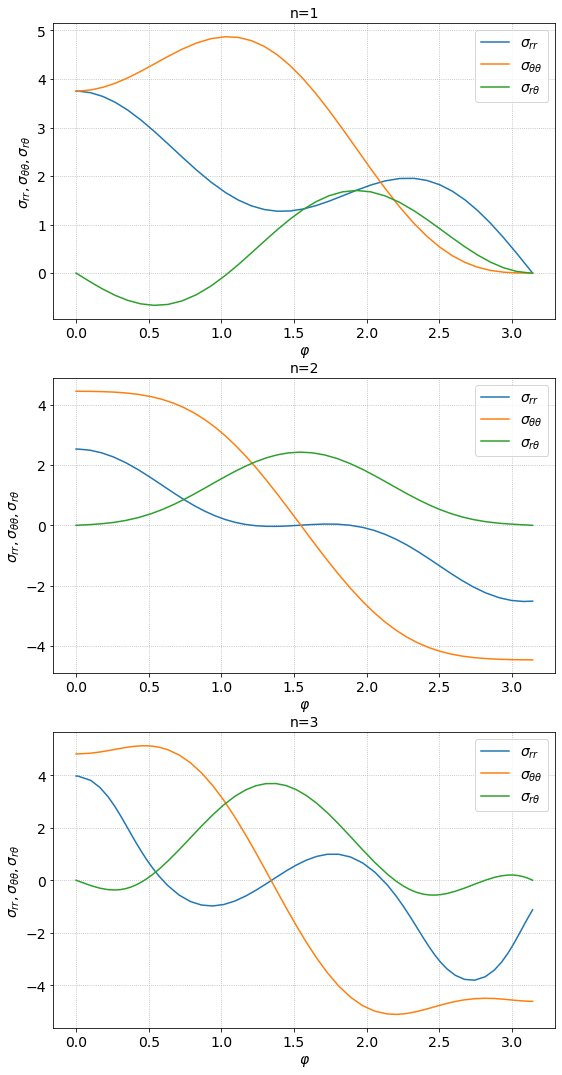

In [6]:
plt.figure(figsize=(9,25))
for i in range(len(nvalues)):    
    plt.subplot(4,1,i+1)
    plt.plot(sol[i][0].t, [sol[i][1](*line) for line in sol[i][0].y.transpose()])
    plt.plot(sol[i][0].t, [sol[i][2](*line) for line in sol[i][0].y.transpose()])
    plt.plot(sol[i][0].t, [sol[i][3](*line) for line in sol[i][0].y.transpose()])
    plt.xlabel('$\\varphi$');
    plt.ylabel('$\sigma_{rr}, \sigma_{\\theta\\theta}, \sigma_{r\\theta}$')
    plt.legend(['$\sigma_{rr}$','$\sigma_{\\theta\\theta}$','$\sigma_{r\\theta}$']);
    plt.grid(linestyle=':');    
    plt.title('n={}'.format(nvalues[i]))

#### Функции f, f', f'', f'''

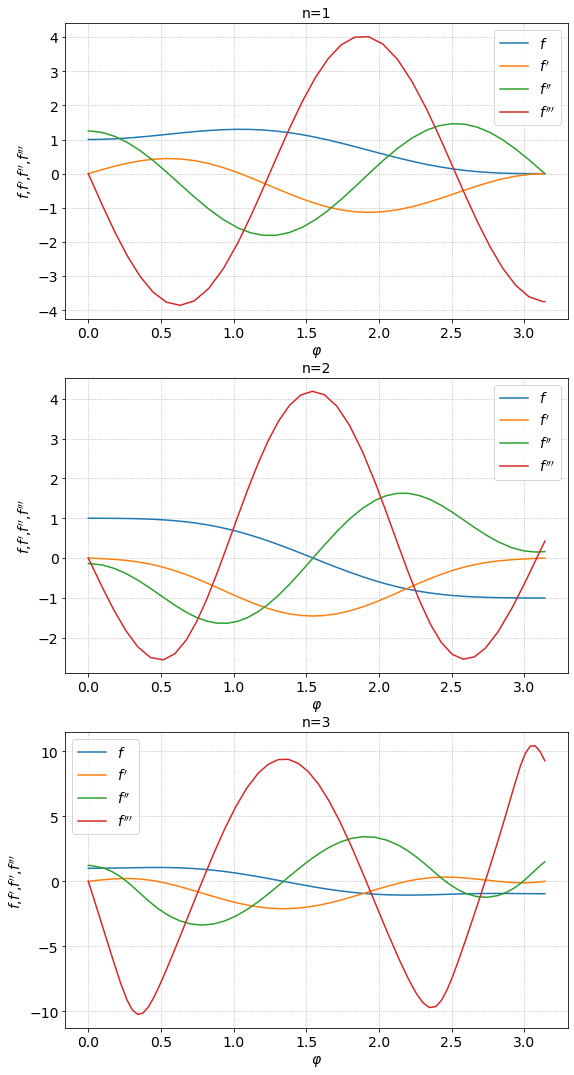

In [7]:
plt.figure(figsize=(9,25))
for i in range(len(nvalues)):   
    plt.subplot(4,1,i+1)
    plt.plot(sol[i][0].t, sol[i][0].y[0])
    plt.plot(sol[i][0].t, sol[i][0].y[1])
    plt.plot(sol[i][0].t, sol[i][0].y[2])
    plt.plot(sol[i][0].t, sol[i][0].y[3])
    plt.xlabel('$\\varphi$');
    plt.ylabel('$f$,$f\'$,$f\'\'$,$f\'\'\'$');
    plt.grid(linestyle=':');
    plt.legend(['$f$','$f\'$','$f\'\'$','$f\'\'\'$']);    
    plt.title('n={}'.format(nvalues[i]))

## Плоское деформированное состояние

Функция, которая возвращает решение для заданного значения n и левой границы f(0) = c1

In [8]:
def get_solution_PD(n_, c1_):
    # Интенсивность напряжений
    # стр. 305, ф. (1.7)     
    T = (3*((sigma_rr-sigma_tt)**2)/4 + 3*sigma_rt**2)**(1/2)
    # Деформации
    epsilon_rr = T**(n-1)*(sigma_rr-(sigma_rr+sigma_tt)/3)
    epsilon_tt = T**(n-1)*(sigma_tt-(sigma_rr+sigma_tt)/3)
    epsilon_rt = T**(n-1)*sigma_rt
    # Замена
    params = [ (l, (2*n_+1)/(n_+1)), (n, n_) ]
    # Диф. уравнение
    eq  = 2*((l-1)*n+1)*sp.diff(epsilon_rt,t) - sp.diff(epsilon_rr,t,2) + (l-1)*n*epsilon_rr - ((l-1)*n+1)*(l-1)*n*epsilon_tt
    # Разрешаем относительно старшей производной (4 порядка)
    # Находим A и B
    # A f'''' = B
    A = eq.subs(params).expand(mul=True).coeff(sp.diff(f(t),t,4))
    B = eq.subs(params).expand(mul=True).as_independent(sp.diff(f(t),t,4))[0]    
    fdfd2fd3f = [f(t), sp.diff(f(t),t), sp.diff(f(t),t,2), sp.diff(f(t),t,3)]
    # Функция вычисления значения 4-ой производной для заданных значений  f, f', f'', f'''
    eqn = sp.lambdify(fdfd2fd3f,sp.simplify(-B/A))    
    # 'Числовые' функции для вычисления значений напряжений по значениям f, f', f'', f'''
    sigma_rr_num = sp.lambdify( fdfd2fd3f, sigma_rr.subs(params))
    sigma_tt_num = sp.lambdify( fdfd2fd3f, sigma_tt.subs(params))
    sigma_rt_num = sp.lambdify( fdfd2fd3f, sigma_rt.subs(params))
    # Функция правых частей системы дифференциальных уравнений
    eq_ode = lambda t, q : np.append(q[1:4],eqn(*q))
    # Функция возвращает решение  f'(pi)
    # для заданных начальный условий f(0) = c1, f''(0) = c2 (ТИП I)
    # Функция необходима для метода пристрелки
    def sol_I(c1, c2):
        sol = solve_ivp(eq_ode, [0, np.pi], [c1_,0,c2,0], rtol = 1e-7)
        return sol.y[1,-1]
    # Находим c2
    c2_Isol = root(lambda c2: sol_I(c1_,c2), 0, tol = 1e-3)
    c2_I = c2_Isol.x[0]
    print('Для n = {:2.0f}, c1 = {:6.3f} найдено c2 = {:6.3f} (f\'(pi)={:+6.4f})'.format(n_, c1_, c2_I,c2_Isol.fun))
    # Решаем ДУ для найденного значния c2 
    sol = solve_ivp(eq_ode, [0.0, np.pi], [c1_, 0, c2_I, 0], rtol = 1e-7)
    return [sol,sigma_rr_num,sigma_tt_num,sigma_rt_num]

### Решение

In [9]:
nvalues = (1,2,4)
sol = []
for i in nvalues:
    sol.append(get_solution_PD(n_ = i, c1_ = 1))

Для n =  1, c1 =  1.000 найдено c2 =  1.250 (f'(pi)=+0.0000)
Для n =  2, c1 =  1.000 найдено c2 = -1.097 (f'(pi)=-0.0000)
Для n =  4, c1 =  1.000 найдено c2 = 10.977 (f'(pi)=-0.0000)


### Результаты

#### Напряжения

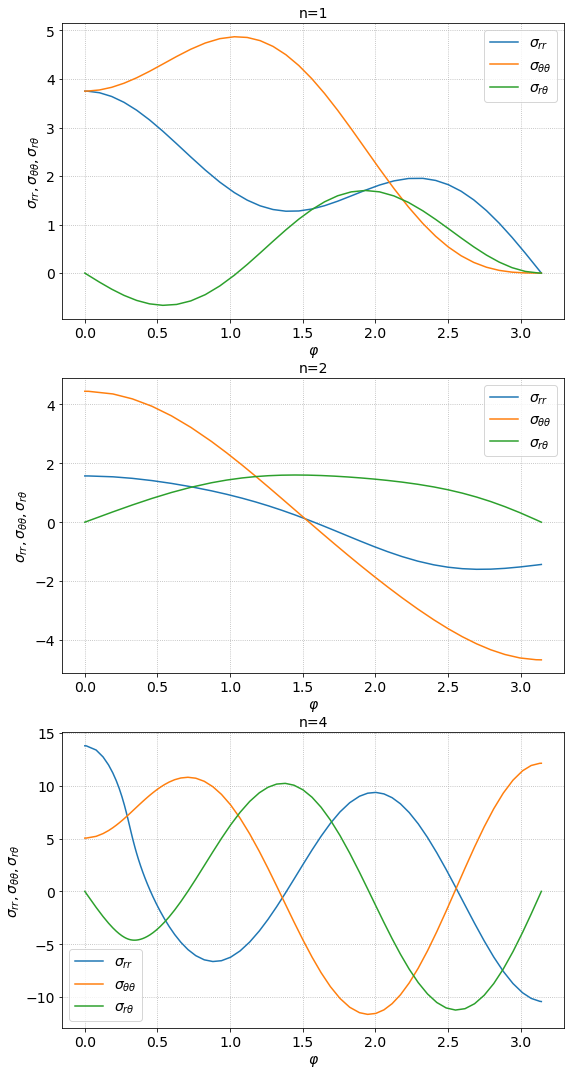

In [10]:
plt.figure(figsize=(9,25))
for i in range(len(nvalues)):    
    plt.subplot(4,1,i+1)
    plt.plot(sol[i][0].t, [sol[i][1](*line) for line in sol[i][0].y.transpose()])
    plt.plot(sol[i][0].t, [sol[i][2](*line) for line in sol[i][0].y.transpose()])
    plt.plot(sol[i][0].t, [sol[i][3](*line) for line in sol[i][0].y.transpose()])
    plt.xlabel('$\\varphi$');
    plt.ylabel('$\sigma_{rr}, \sigma_{\\theta\\theta}, \sigma_{r\\theta}$')
    plt.legend(['$\sigma_{rr}$','$\sigma_{\\theta\\theta}$','$\sigma_{r\\theta}$']);
    plt.grid(linestyle=':');    
    plt.title('n={}'.format(nvalues[i]))

#### Функции f, f', f'', f'''

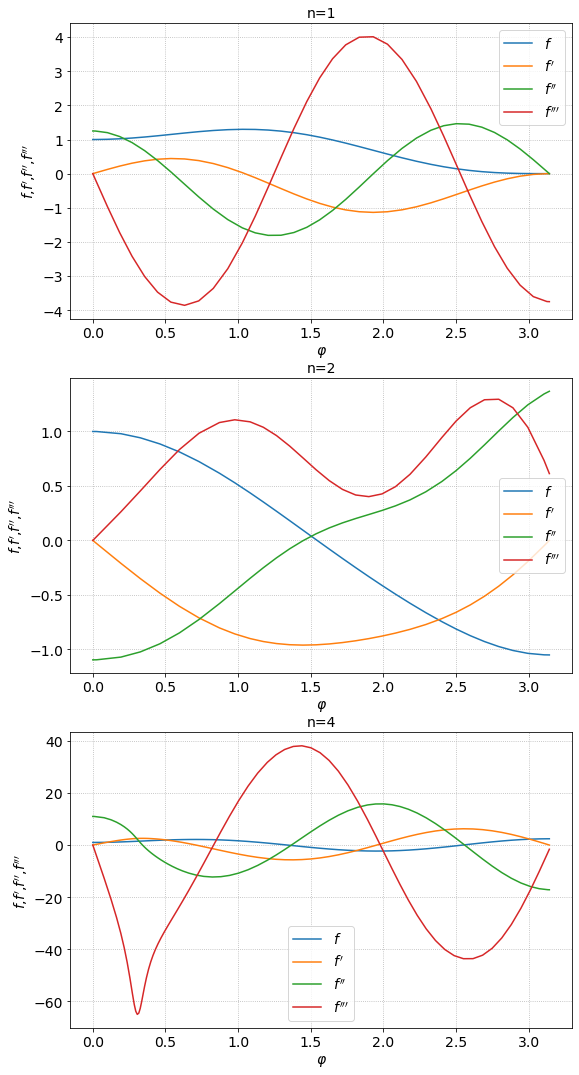

In [11]:
plt.figure(figsize=(9,25))
for i in range(len(nvalues)):   
    plt.subplot(4,1,i+1)
    plt.plot(sol[i][0].t, sol[i][0].y[0])
    plt.plot(sol[i][0].t, sol[i][0].y[1])
    plt.plot(sol[i][0].t, sol[i][0].y[2])
    plt.plot(sol[i][0].t, sol[i][0].y[3])
    plt.xlabel('$\\varphi$');
    plt.ylabel('$f$,$f\'$,$f\'\'$,$f\'\'\'$');
    plt.grid(linestyle=':');
    plt.legend(['$f$','$f\'$','$f\'\'$','$f\'\'\'$']);    
    plt.title('n={}'.format(nvalues[i]))